# Import Data

In [1]:
import pandas as pd
from collections import Counter
import spacy
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

import datetime

In [2]:
basepath = "C:/Users/Alvis Cheung/Desktop/Bayes/Term 3/Applied Research Project/Data Ready/"

In [3]:
df_PA = pd.read_csv(basepath+"pushshift_abarth_20230509.csv")
df_PAcm = pd.read_csv(basepath+"pushshift_abarth_cm_20230509.csv")
df_PF = pd.read_csv(basepath+"pushshift_fiat_abarth_20230519.csv")
df_PFcm = pd.read_csv(basepath+"pushshift_fiat_abarth_cm_20230520.csv")

df_RA = pd.read_csv(basepath+"redditapi_abarth_20230509.csv")
df_RAcm = pd.read_csv(basepath+"redditapi_abarth_cm_20230509.csv")
df_RF = pd.read_csv(basepath+"redditapi_fiat_abarth_20230509.csv")
df_RFcm = pd.read_csv(basepath+"redditapi_fiat_abarth_cm_20230509.csv")



df_PA = df_PA.drop(columns=['Unnamed: 0'])
df_PAcm = df_PAcm.drop(columns=['Unnamed: 0'])
df_PF = df_PF.drop(columns=['Unnamed: 0'])
df_PFcm = df_PFcm.drop(columns=['Unnamed: 0'])

df_RA = df_RA.drop(columns=['Unnamed: 0'])
df_RAcm = df_RAcm.drop(columns=['Unnamed: 0'])
df_RF = df_RF.drop(columns=['Unnamed: 0'])
df_RFcm = df_RFcm.drop(columns=['Unnamed: 0'])

In [4]:
df_RFcm[['text','time']]

,text,time
0,Whaaat? 500L is a complete different car to a ...,1.682692e+09
1,I have a 2014 500l with 110000 miles. Firesto...,1.682725e+09
2,"idk what a doblo is, i live in the US",1.682702e+09
3,"they are pretty worn out, the front ones clunk...",1.682741e+09
4,I think they are sold as Ram Promaster.,1.682704e+09
...,...,...
1039,2015 owner in Michigan here. 1 pretty snowy wi...,1.506387e+09
1040,Much appreciated!,1.505656e+09
1041,So I've owned my Abarth since new in 2014. Hav...,1.505697e+09
1042,Thanks for your input (very helpful coming fro...,1.505698e+09


In [5]:
frames = [df_PA[['text','time']], 
         df_PAcm[['text','time']], 
         df_PF[['text','time']],
         df_PFcm[['text','time']], 
         df_RA[['text','time']], 
         df_RAcm[['text','time']], 
         df_RF[['text','time']], 
         df_RFcm[['text','time']]]
df = pd.concat(frames)
df

,text,time
0,"Hello everyone, I own a 2016 Abarth 595 which ...",1.650410e+09
1,NaN,1.650404e+09
2,[deleted],1.650334e+09
3,NaN,1.650333e+09
4,NaN,1.650317e+09
...,...,...
1039,2015 owner in Michigan here. 1 pretty snowy wi...,1.506387e+09
1040,Much appreciated!,1.505656e+09
1041,So I've owned my Abarth since new in 2014. Hav...,1.505697e+09
1042,Thanks for your input (very helpful coming fro...,1.505698e+09


In [6]:
df.text.value_counts()

text
[deleted]                                                                                                                                                                                                                                                                                                                                                                                  2004
[removed]                                                                                                                                                                                                                                                                                                                                                                                   802
Thanks!                                                                                                                                                                                                                            

# Cleaning

## Remove empty inputs

In [7]:
dfClean = df[(df.text!="[deleted]") &
             (df.text!="[removed]") &
             (df.text.notna())]
dfClean.text.value_counts()

text
Thanks!                                                                                                                                                                                                                                                                                                                                                                                    104
Thank you!                                                                                                                                                                                                                                                                                                                                                                                  74
Thanks                                                                                                                                                                                                                               

In [8]:
dfCleanText = dfClean.loc[dfClean.text.notnull()].reset_index(drop=True)
dfCleanText

,text,time
0,"Hello everyone, I own a 2016 Abarth 595 which ...",1.650410e+09
1,"Hello fellas,\n\nI got a ‘19 Competizione Seri...",1.650274e+09
2,I wasn’t able to find dryflow air filters for ...,1.650142e+09
3,I'll buy from EC if need be but if I can save ...,1.650043e+09
4,Any one know what could be going on? My ESC li...,1.649988e+09
...,...,...
61561,2015 owner in Michigan here. 1 pretty snowy wi...,1.506387e+09
61562,Much appreciated!,1.505656e+09
61563,So I've owned my Abarth since new in 2014. Hav...,1.505697e+09
61564,Thanks for your input (very helpful coming fro...,1.505698e+09


In [9]:
data = dfCleanText.text
data

0        Hello everyone, I own a 2016 Abarth 595 which ...
1        Hello fellas,\n\nI got a ‘19 Competizione Seri...
2        I wasn’t able to find dryflow air filters for ...
3        I'll buy from EC if need be but if I can save ...
4        Any one know what could be going on? My ESC li...
                               ...                        
61561    2015 owner in Michigan here. 1 pretty snowy wi...
61562                                    Much appreciated!
61563    So I've owned my Abarth since new in 2014. Hav...
61564    Thanks for your input (very helpful coming fro...
61565    Thanks for the post! Another fellow Canadian b...
Name: text, Length: 61566, dtype: object

## cleaning & tokenization

In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
nlp(data[0]).lang_

'en'

In [12]:
# filter for english comments
# remove stop-words, punctuations, non-English alphabets
def preprocess(text):
    doc = nlp(text)
    isEng = doc.lang_=='en'
    return [token.lemma_.lower() for token in doc
            if not token.is_stop and not token.is_punct and token.is_alpha]*isEng + []*(not isEng)

In [13]:
# basic cleaning and tokenisation
tkn_docs = [preprocess(text) for text in tqdm(data)]
tkn_docs = [t for t in tkn_docs if t != []]
tkn_docs

100%|██████████| 61566/61566 [12:59<00:00, 79.03it/s] 


[['hello',
  'abarth',
  'develop',
  'squealing',
  'noise',
  'think',
  'brake',
  'need',
  'replacement',
  'look',
  'upgrade',
  'stock',
  'brake',
  'get',
  'suggestion',
  'upgrade',
  'cost',
  'help',
  'appreciate'],
 ['hello',
  'fellas',
  'get',
  'competizione',
  'series',
  'eu',
  'configuration',
  'want',
  'export',
  'florida',
  'know',
  'possible',
  'register',
  'car',
  'order',
  'advice',
  'welcome',
  'great',
  'day'],
 ['able',
  'find',
  'dryflow',
  'air',
  'filter',
  'want',
  'deal',
  'oil',
  'base',
  'air',
  'filter',
  'like',
  'look',
  'well',
  'airflow',
  'ease',
  'maintenance',
  'expect',
  'power',
  'gain',
  'aem',
  'dryflow',
  'mile',
  'great',
  'recommendation',
  'great'],
 ['buy', 'ec', 'need', 'save', 'go', 'to', 'lol'],
 ['know',
  'go',
  'esc',
  'light',
  'come',
  'highway',
  'car',
  'drive',
  'fine',
  'normal',
  'cause',
  'check',
  'engine',
  'light',
  'come'],
 ['difference',
  'bhp',
  'autotrader'

In [14]:
# filter for long comments (at least 10 tokens)
tkn_long = [t for t in tkn_docs if len(t)>=10]
len(tkn_long)

28580

# gensim Topic Modelling (whole dataset)

In [15]:
# load library
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import gensim
import pyLDAvis

In [16]:
# convert the data into gensim lda model required format
bigram = Phrases(tkn_long)
bigram_tkns = [bigram[line] for line in tkn_long]
bigram_tkns = [bigram[line] for line in tkn_long]

dictionary = Dictionary(bigram_tkns)
corpus = [dictionary.doc2bow(text) for text in bigram_tkns]

In [17]:
# check most frequent words
dictionary.most_common(100)

[('car', 16855),
 ('abarth', 8534),
 ('like', 6297),
 ('look', 5894),
 ('drive', 5433),
 ('get', 5234),
 ('fiat', 5172),
 ('go', 4287),
 ('buy', 4269),
 ('think', 4198),
 ('good', 4139),
 ('time', 3758),
 ('know', 3740),
 ('want', 3634),
 ('need', 3434),
 ('work', 3356),
 ('new', 3283),
 ('issue', 3257),
 ('find', 3126),
 ('mile', 3112),
 ('thing', 2996),
 ('engine', 2876),
 ('come', 2601),
 ('year', 2540),
 ('replace', 2475),
 ('way', 2305),
 ('sure', 2297),
 ('try', 2254),
 ('love', 2189),
 ('lot', 2138),
 ('problem', 2086),
 ('well', 2085),
 ('little', 2046),
 ('start', 2008),
 ('say', 1988),
 ('run', 1958),
 ('turbo', 1957),
 ('use', 1893),
 ('check', 1886),
 ('change', 1856),
 ('stock', 1831),
 ('great', 1775),
 ('bad', 1740),
 ('right', 1737),
 ('people', 1729),
 ('thank', 1715),
 ('wheel', 1695),
 ('dealer', 1628),
 ('bit', 1618),
 ('probably', 1612),
 ('take', 1585),
 ('model', 1576),
 ('pretty', 1563),
 ('day', 1511),
 ('oil', 1495),
 ('fix', 1492),
 ('see', 1480),
 ('fun', 14

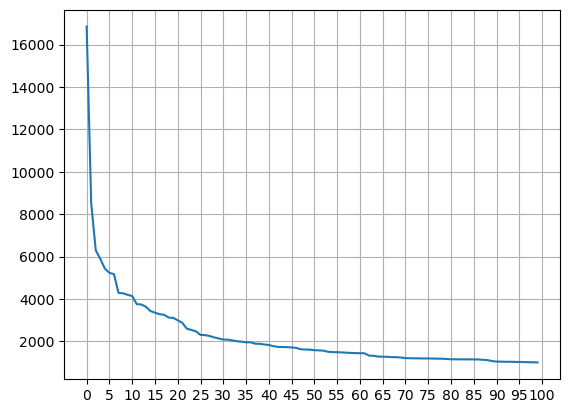

In [18]:
# frequency plot
plt.plot(np.arange(0,100), [v for k,v in dictionary.most_common(100)])
plt.xticks(np.arange(0,105,5))
plt.grid(True)

In [99]:
# put all to-be-removed words in a list (top 10 most frequent words + several other)
# remove those words from the token list
# convert the data into gensim lda model required format 
most_frequent_words = [x[0] for x in dictionary.most_common(10)] + ['good', 'want', 'know']
tkns_remove_top = [[tkn for tkn in texts if tkn not in most_frequent_words] for texts in bigram_tkns]
dictionary1 = Dictionary(tkns_remove_top)
corpus1 = [dictionary1.doc2bow(text) for text in tkns_remove_top]

# calculate the cohenrence scores for models of diff number of topics
coh_scores = []
for num_topics in tqdm(np.arange(5,21)):
    # lda topic modelling
    lda_model = LdaModel(
        corpus=corpus1, num_topics=num_topics, id2word=dictionary1, random_state=123)
    # model to get the coherence score
    coherence_model_lda = CoherenceModel(
        model=lda_model, texts=tkns_remove_top, dictionary=dictionary1, coherence='c_v')
    coh_scores.append(coherence_model_lda.get_coherence())
    
coh_scores

100%|██████████| 16/16 [07:31<00:00, 28.22s/it]


[0.5892188842717518,
 0.5759783096611586,
 0.5655537949333339,
 0.5920861021366683,
 0.5640177144353051,
 0.5350730733247324,
 0.5661670614717802,
 0.5800472954092157,
 0.5408092097421042,
 0.531478478303074,
 0.5421567995044712,
 0.5050600741933826,
 0.5089529659701174,
 0.5044548364440969,
 0.4889849558487467,
 0.4605386650603015]

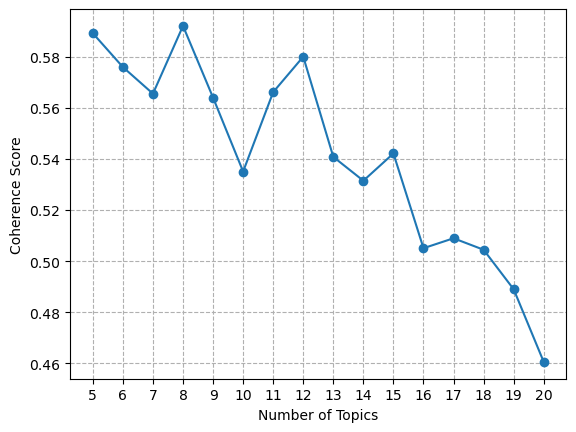

In [100]:
# plot coherence score VS number of topics
plt.plot(np.arange(5,21), coh_scores, marker="o")
plt.ylabel("Coherence Score")
plt.xlabel("Number of Topics")
plt.xticks(np.arange(5,21))
plt.grid(True, ls="--")

In [294]:
# define the optimal number of topics (highest coherence score, less topics)
bestNum = 6
lda_model = LdaModel(
    corpus=corpus1, num_topics=bestNum, id2word=dictionary1, random_state=123)

In [295]:
lda_model.save("LDAmodel")

In [296]:
lda_model = LdaModel.load("LDAmodel")

In [297]:
# show the topics' words
lda_model.show_topics(num_words = 8)

[(0,
  '0.014*"mile" + 0.012*"oil" + 0.012*"dealer" + 0.012*"issue" + 0.011*"replace" + 0.011*"engine" + 0.010*"warranty" + 0.009*"check"'),
 (1,
  '0.010*"time" + 0.010*"issue" + 0.009*"engine" + 0.009*"start" + 0.007*"turn" + 0.006*"light" + 0.006*"run" + 0.006*"work"'),
 (2,
  '0.008*"people" + 0.008*"find" + 0.007*"work" + 0.007*"love" + 0.007*"miata" + 0.006*"price" + 0.006*"time" + 0.006*"great"'),
 (3,
  '0.010*"work" + 0.008*"tune" + 0.007*"radio" + 0.007*"sure" + 0.006*"model" + 0.006*"use" + 0.006*"need" + 0.006*"new"'),
 (4,
  '0.008*"wheel" + 0.008*"find" + 0.007*"model" + 0.006*"light" + 0.006*"red" + 0.006*"black" + 0.006*"color" + 0.005*"one"'),
 (5,
  '0.009*"new" + 0.008*"love" + 0.008*"well" + 0.007*"fun" + 0.007*"turbo" + 0.007*"mile" + 0.006*"need" + 0.006*"tire"')]

## check example comments for each topic

In [298]:
# doc-to-topic probability
doc2topic = [lda_model.get_document_topics(corp, minimum_probability=0) for corp in corpus1] #list of lists of tuples

doc2top = [{t:p for t,p in LL} for LL in doc2topic]
doc2top = pd.DataFrame(doc2top).values.tolist()
doc2top = np.array(doc2top)

doc2top /= doc2top.sum(axis=1, keepdims=True)

In [299]:
## check examples for each topic
for i, topic in enumerate(lda_model.show_topics(num_words = 8)):
    print("Topic", topic[0])
    print(topic[1])
    print("------------------------------------------------------")
    print("Examples:")
    for count, index in enumerate(pd.DataFrame(doc2top).sort_values(by=[i], ascending=False).reset_index()['index'][:10].to_list()):
        print(count,")",data[index])
    print("===================================================================")
    print()



Topic 0
0.014*"mile" + 0.012*"oil" + 0.012*"dealer" + 0.012*"issue" + 0.011*"replace" + 0.011*"engine" + 0.010*"warranty" + 0.009*"check"
------------------------------------------------------
Examples:
0 ) Agreed, someone called it marshamallow though and that's also a fitting name to the color.
1 ) Bin having some troubles finding an intake for EU model t-jet engine, atleast every mail i send for info has bin left unresponded lol
2 ) Car is a 2013 Abarth Punto Supersport (1.4 Multiair.) 

The intake hose that goes from the air box to the turbo inlet (that is fixed by a crappy OEM clic clamp) keeps getting a bit dislodged from the turbo inlet after a drive. 

I'm still trying to find a hose clamp with the appropriate width to replace the clic type clamp, to see if it fixes the issue. Kinda wondering if it might be the early signs of a bad engine mount letting the engine move too much and dislodging the tubing. 

I know this is mainly a US 500 sub, and I think the whole setup is kinda 

## pyLDAvis

In [300]:
print("Num docs:",len(tkn_long))
print("Num Vocabs:",len(dictionary1))
print("Num topics:", bestNum)

Num docs: 28580
Num Vocabs: 23108
Num topics: 6


In [301]:
# topic-to-word probability
topic2word = lda_model.state.get_lambda()
topic2word.shape, topic2word

((6, 23108),
 array([[4.0078152e+01, 3.1029578e+02, 3.3073986e+01, ..., 1.6672257e-01,
         4.3187225e-01, 1.6710016e-01],
        [4.7467438e+02, 1.1818769e+02, 7.9984198e+00, ..., 1.6671574e-01,
         1.6668865e-01, 1.6706020e-01],
        [1.3292244e+02, 2.2056332e+02, 7.5956669e+00, ..., 1.6673014e-01,
         2.1740106e-01, 1.6717035e-01],
        [3.6244858e+01, 6.0515751e+01, 1.6836536e-01, ..., 1.6674857e-01,
         1.6670451e-01, 1.6734026e-01],
        [5.1723790e+00, 4.8202747e+01, 2.7050692e-01, ..., 3.2858360e-01,
         1.7479983e-01, 1.6728270e-01],
        [1.4014592e+02, 2.0895326e+02, 2.6526098e+01, ..., 3.2388705e-01,
         1.6668716e-01, 1.3546891e+00]], dtype=float32))

In [302]:
doc2top.shape, doc2top

((28580, 6),
 array([[0.13634795, 0.01127767, 0.01120585, 0.01127406, 0.01117355,
         0.81872092],
        [0.01051296, 0.0104822 , 0.01060214, 0.13003439, 0.82784735,
         0.01052097],
        [0.71037944, 0.00911815, 0.25324897, 0.00907176, 0.00906367,
         0.00911801],
        ...,
        [0.00523197, 0.29561532, 0.00524016, 0.00523511, 0.0052511 ,
         0.68342633],
        [0.04041587, 0.34556545, 0.01731618, 0.16055973, 0.15689882,
         0.27924395],
        [0.01860181, 0.01855968, 0.76850582, 0.15702538, 0.01865109,
         0.01865622]]))

In [303]:
# dictionary
vocab = [v for k,v in dictionary1.items()]

# length of each document
doc_lengths = [len(doc) for doc in tkns_remove_top]

# frequency of each word in the whole dataset
term_frequency = dictionary1.cfs
myKeys = list(term_frequency.keys())
myKeys.sort()
term_frequency = {i: term_frequency[i] for i in myKeys}

prepared_data = pyLDAvis.prepare(
    topic2word, 
    doc2top, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, 
    sort_topics=False 
)

In [313]:
pyLDAvis.save_html(prepared_data, 'ldavis_whole.html')
pyLDAvis.display(prepared_data)

# Topic Modelling before & after launch

## split by annoucement date (22 Nov 2022)

In [182]:
datetime.datetime.fromtimestamp(max(dfCleanText.time)), datetime.datetime.fromtimestamp(min(dfCleanText.time))

(datetime.datetime(2023, 5, 18, 17, 54, 25),
 datetime.datetime(2013, 6, 21, 13, 13, 25))

In [188]:
dfCleanText.time = pd.to_datetime(dfCleanText.time,unit='s')

In [219]:
announce = datetime.datetime(2022,11,22,0,0,0)
dfBefore = dfCleanText[dfCleanText.time<announce]
dfAfter = dfCleanText[dfCleanText.time>=announce]
dfBefore.reset_index(drop=True,inplace=True)
dfAfter.reset_index(drop=True,inplace=True)

In [192]:
max(dfBefore.time), min(dfAfter.time)

(Timestamp('2022-11-21 23:46:57'), Timestamp('2022-11-22 05:58:36'))

In [221]:
dataBefore = dfBefore.text
dataAfter = dfAfter.text

## before launch (same codes)

In [194]:
# basic cleaning and tokenisation
tkn_docsB = [preprocess(text) for text in tqdm(dataBefore)]
tkn_docsB = [t for t in tkn_docsB if t != []]

# filter for long comments
tkn_longB = [t for t in tkn_docsB if len(t)>=10]

100%|██████████| 56748/56748 [13:17<00:00, 71.15it/s] 


In [199]:
# convert the data into gensim lda model required format
bigramB = Phrases(tkn_longB)
bigram_tknsB = [bigramB[line] for line in tkn_longB]

dictionaryB = Dictionary(bigram_tknsB)
corpusB = [dictionaryB.doc2bow(text) for text in bigram_tknsB]

# check most frequent words
dictionaryB.most_common(100)

[('car', 15849),
 ('abarth', 7989),
 ('like', 5861),
 ('look', 5499),
 ('drive', 5108),
 ('get', 4887),
 ('fiat', 4852),
 ('buy', 4055),
 ('go', 4001),
 ('think', 3953),
 ('good', 3874),
 ('time', 3518),
 ('know', 3482),
 ('want', 3383),
 ('need', 3164),
 ('work', 3080),
 ('new', 3065),
 ('issue', 3041),
 ('mile', 2955),
 ('find', 2922),
 ('thing', 2843),
 ('engine', 2644),
 ('come', 2452),
 ('year', 2404),
 ('replace', 2283),
 ('way', 2142),
 ('sure', 2128),
 ('try', 2087),
 ('lot', 2080),
 ('love', 2056),
 ('problem', 1968),
 ('well', 1929),
 ('little', 1921),
 ('say', 1875),
 ('turbo', 1854),
 ('start', 1839),
 ('run', 1807),
 ('use', 1756),
 ('check', 1731),
 ('stock', 1697),
 ('great', 1680),
 ('people', 1629),
 ('thank', 1622),
 ('right', 1622),
 ('bad', 1618),
 ('change', 1566),
 ('wheel', 1551),
 ('dealer', 1545),
 ('bit', 1509),
 ('pretty', 1502),
 ('probably', 1502),
 ('model', 1491),
 ('take', 1489),
 ('day', 1416),
 ('see', 1399),
 ('fix', 1394),
 ('fun', 1386),
 ('long', 1

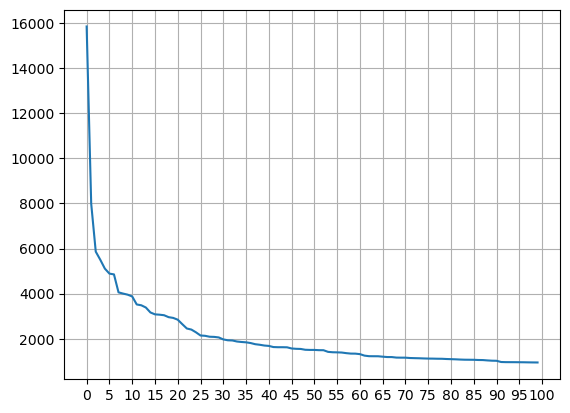

In [196]:
# frequency plot
plt.plot(np.arange(0,100), [v for k,v in dictionaryB.most_common(100)])
plt.xticks(np.arange(0,105,5))
plt.grid(True)

100%|██████████| 16/16 [07:07<00:00, 26.69s/it]


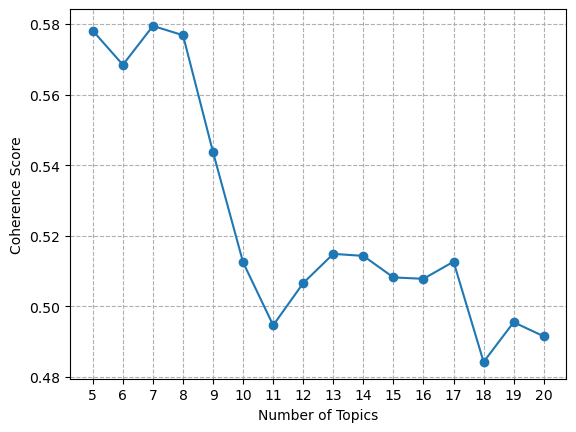

In [197]:
# put all to-be-removed words in a list (top 10 most frequent words + several other)
# remove those words from the token list
# convert the data into gensim lda model required format 
most_frequent_wordsB = [x[0] for x in dictionaryB.most_common(10)]
tkns_remove_topB = [[tkn for tkn in texts if tkn not in most_frequent_wordsB] for texts in bigram_tknsB]
dictionary1B = Dictionary(tkns_remove_topB)
corpus1B = [dictionary1B.doc2bow(text) for text in tkns_remove_topB]

# calculate the cohenrence scores for models of diff number of topics
coh_scoresB = []
for num_topics in tqdm(np.arange(5,21)):
    # lda topic modelling
    lda_model = LdaModel(
        corpus=corpus1B, num_topics=num_topics, id2word=dictionary1B, random_state=123)
    # model to get the coherence score
    coherence_model_lda = CoherenceModel(
        model=lda_model, texts=tkns_remove_topB, dictionary=dictionary1B, coherence='c_v')
    coh_scoresB.append(coherence_model_lda.get_coherence())
    
# plot coherence score VS number of topics
plt.plot(np.arange(5,21), coh_scoresB, marker="o")
plt.ylabel("Coherence Score")
plt.xlabel("Number of Topics")
plt.xticks(np.arange(5,21))
plt.grid(True, ls="--")

In [305]:
# define the optimal number of topics (highest coherence score, less topics)
bestNumB = 5
lda_modelB = LdaModel(
    corpus=corpus1B, num_topics=bestNumB, id2word=dictionary1B, random_state=123)

# save & load model
lda_modelB.save("LDAmodel_before")
lda_modelB = LdaModel.load("LDAmodel_before")

# show the topics' words
lda_modelB.show_topics(num_words = 8)

[(0,
  '0.008*"want" + 0.008*"wheel" + 0.007*"fit" + 0.007*"find" + 0.007*"come" + 0.006*"need" + 0.006*"well" + 0.006*"rear"'),
 (1,
  '0.014*"tire" + 0.011*"wheel" + 0.009*"new" + 0.007*"good" + 0.007*"love" + 0.007*"red" + 0.006*"color" + 0.006*"nice"'),
 (2,
  '0.012*"good" + 0.007*"stock" + 0.007*"want" + 0.006*"new" + 0.005*"great" + 0.005*"well" + 0.005*"tune" + 0.005*"price"'),
 (3,
  '0.010*"work" + 0.009*"need" + 0.008*"time" + 0.008*"manual" + 0.007*"check" + 0.007*"use" + 0.007*"want" + 0.007*"oil"'),
 (4,
  '0.014*"issue" + 0.010*"mile" + 0.009*"thing" + 0.009*"engine" + 0.008*"time" + 0.007*"problem" + 0.007*"replace" + 0.006*"know"')]

In [306]:
# doc-to-topic probability
doc2topicB = [lda_modelB.get_document_topics(corp, minimum_probability=0) for corp in corpus1B] #list of lists of tuples

doc2topB = [{t:p for t,p in LL} for LL in doc2topicB]
doc2topB = pd.DataFrame(doc2topB).values.tolist()
doc2topB = np.array(doc2topB)

doc2topB /= doc2topB.sum(axis=1, keepdims=True)

In [307]:
## check examples for each topic
# print examples
for i, topic in enumerate(lda_modelB.show_topics(num_words = 8)):
    print("Topic", topic[0])
    print(topic[1])
    print("------------------------------------------------------")
    print("Examples:")
    for count, index in enumerate(pd.DataFrame(doc2topB).sort_values(by=[i], ascending=False).reset_index()['index'][:5].to_list()):
        print(count,")",dataBefore[index])
    print("===================================================================")
    print()

Topic 0
0.008*"want" + 0.008*"wheel" + 0.007*"fit" + 0.007*"find" + 0.007*"come" + 0.006*"need" + 0.006*"well" + 0.006*"rear"
------------------------------------------------------
Examples:
0 ) I own a 2017 Abarth with 3800 miles on it. How often would you change the oil? Once a year?  More, since it is sitting around, not being driven? Less, because it is sitting around, not being driven?
1 ) An Abarth would be fun if as a first car but I'm afraid that you'll enjoy it a bit too much because driving it fast is almost too much fun. You can always opt for a cheaper version and have it tuned later, the tuned versions have more torque anyway.

A Renault Zoe would be suicidal though, anything but that.
2 ) Lol, not on purpose...
3 ) I also just bought my first! 2015 Manual, but in white with the black striping. Picking it up on Friday. Super stoked! Bring on the neighbor complaints :) Do you mind me asking what you paid for it?
4 ) Oof

Topic 1
0.014*"tire" + 0.011*"wheel" + 0.009*"new" + 

In [315]:
## pyLDAvis

# topic-to-word probability
topic2wordB = lda_modelB.state.get_lambda()

# dictionary
vocabB = [v for k,v in dictionary1B.items()]

# length of each document
doc_lengthsB = [len(doc) for doc in tkns_remove_topB]

# frequency of each word in the whole dataset
term_frequencyB = dictionary1B.cfs
myKeys = list(term_frequencyB.keys())
myKeys.sort()
term_frequencyB = {i: term_frequencyB[i] for i in myKeys}

prepared_dataB = pyLDAvis.prepare(
    topic2wordB, 
    doc2topB, 
    doc_lengthsB, 
    vocabB, 
    term_frequencyB,
    start_index=0, 
    sort_topics=False 
)

In [316]:
pyLDAvis.save_html(prepared_dataB, 'ldavis_before.html')
pyLDAvis.display(prepared_dataB)

## after launch (same code)

In [200]:
# basic cleaning and tokenisation
tkn_docsA = [preprocess(text) for text in tqdm(dataAfter)]
tkn_docsA = [t for t in tkn_docsA if t != []]

# filter for long comments
tkn_longA = [t for t in tkn_docsA if len(t)>=10]

#=========================================================

# convert the data into gensim lda model required format
bigramA = Phrases(tkn_longA)
bigram_tknsA = [bigramA[line] for line in tkn_longA]

dictionaryA = Dictionary(bigram_tknsA)
corpusA = [dictionaryA.doc2bow(text) for text in bigram_tknsA]

# check most frequent words
dictionaryA.most_common(100)

100%|██████████| 4818/4818 [00:55<00:00, 86.35it/s] 


[('car', 1006),
 ('abarth', 547),
 ('like', 430),
 ('look', 399),
 ('get', 359),
 ('drive', 343),
 ('fiat', 296),
 ('go', 295),
 ('work', 284),
 ('good', 270),
 ('know', 258),
 ('engine', 254),
 ('want', 251),
 ('need', 247),
 ('think', 245),
 ('time', 243),
 ('new', 224),
 ('issue', 222),
 ('buy', 222),
 ('find', 213),
 ('wheel', 180),
 ('mile', 180),
 ('start', 177),
 ('replace', 171),
 ('sure', 170),
 ('try', 169),
 ('check', 167),
 ('oil', 165),
 ('way', 163),
 ('come', 163),
 ('run', 161),
 ('well', 156),
 ('thing', 155),
 ('change', 150),
 ('year', 147),
 ('stock', 141),
 ('turbo', 141),
 ('love', 139),
 ('right', 137),
 ('use', 137),
 ('thank', 133),
 ('sound', 131),
 ('little', 130),
 ('problem', 129),
 ('bad', 128),
 ('tire', 126),
 ('bit', 120),
 ('light', 118),
 ('part', 118),
 ('long', 114),
 ('probably', 112),
 ('say', 110),
 ('exhaust', 110),
 ('make', 110),
 ('help', 108),
 ('sell', 108),
 ('lot', 107),
 ('big', 106),
 ('not', 106),
 ('fix', 106),
 ('take', 104),
 ('day'

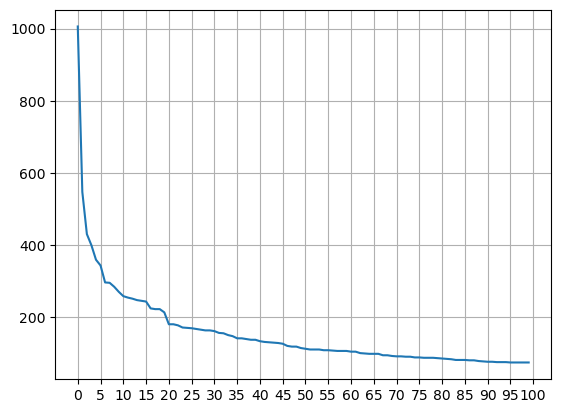

In [201]:
# frequency plot
plt.plot(np.arange(0,100), [v for k,v in dictionaryA.most_common(100)])
plt.xticks(np.arange(0,105,5))
plt.grid(True)

100%|██████████| 16/16 [03:04<00:00, 11.55s/it]


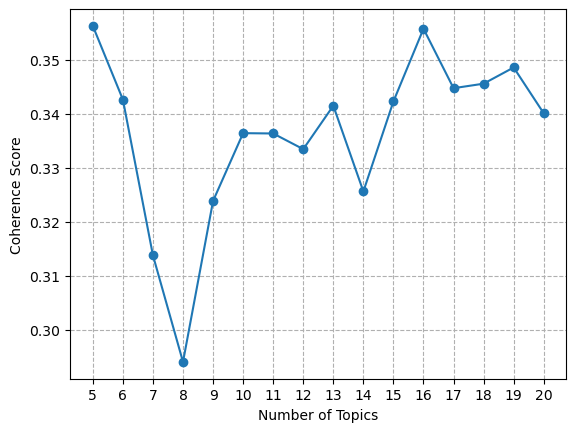

In [233]:
# put all to-be-removed words in a list (top 10 most frequent words + several other)
# remove those words from the token list
# convert the data into gensim lda model required format 
most_frequent_wordsA = [x[0] for x in dictionaryA.most_common(7)]
tkns_remove_topA = [[tkn for tkn in texts if tkn not in most_frequent_wordsA] for texts in bigram_tknsA]
dictionary1A = Dictionary(tkns_remove_topA)
corpus1A = [dictionary1A.doc2bow(text) for text in tkns_remove_topA]

# calculate the cohenrence scores for models of diff number of topics
coh_scoresA = []
for num_topics in tqdm(np.arange(5,21)):
    # lda topic modelling
    lda_model = LdaModel(
        corpus=corpus1A, num_topics=num_topics, id2word=dictionary1A, random_state=123)
    # model to get the coherence score
    coherence_model_lda = CoherenceModel(
        model=lda_model, texts=tkns_remove_topA, dictionary=dictionary1A, coherence='c_v')
    coh_scoresA.append(coherence_model_lda.get_coherence())
    
# plot coherence score VS number of topics
plt.plot(np.arange(5,21), coh_scoresA, marker="o")
plt.ylabel("Coherence Score")
plt.xlabel("Number of Topics")
plt.xticks(np.arange(5,21))
plt.grid(True, ls="--")

In [309]:
# define the optimal number of topics (highest coherence score, less topics)
bestNumA = 6
lda_modelA = LdaModel(
    corpus=corpus1A, num_topics=bestNumA, id2word=dictionary1A, random_state=123)

# save & load model
lda_modelA.save("LDAmodel_after")
lda_modelA = LdaModel.load("LDAmodel_after")

# show the topics' words
lda_modelA.show_topics(num_words = 8)

[(0,
  '0.010*"start" + 0.009*"time" + 0.008*"use" + 0.007*"check" + 0.007*"filter" + 0.007*"good" + 0.006*"mile" + 0.006*"work"'),
 (1,
  '0.013*"want" + 0.009*"engine" + 0.008*"work" + 0.008*"stock" + 0.007*"new" + 0.007*"mile" + 0.007*"ev" + 0.007*"little"'),
 (2,
  '0.009*"time" + 0.009*"start" + 0.009*"vehicle" + 0.008*"clutch_switch" + 0.007*"relay" + 0.006*"purchase" + 0.006*"little" + 0.006*"blow"'),
 (3,
  '0.010*"take" + 0.009*"know" + 0.007*"love" + 0.006*"time" + 0.006*"work" + 0.006*"experience" + 0.006*"want" + 0.006*"mile"'),
 (4,
  '0.011*"strut" + 0.010*"mile" + 0.009*"go" + 0.009*"tire" + 0.009*"rear" + 0.009*"socket" + 0.009*"far" + 0.008*"hear"'),
 (5,
  '0.008*"new" + 0.008*"good" + 0.007*"light" + 0.007*"love" + 0.007*"right" + 0.006*"wire" + 0.006*"performance" + 0.006*"think"')]

In [310]:
# doc-to-topic probability
doc2topicA = [lda_modelA.get_document_topics(corp, minimum_probability=0) for corp in corpus1A] #list of lists of tuples

doc2topA = [{t:p for t,p in LL} for LL in doc2topicA]
doc2topA = pd.DataFrame(doc2topA).values.tolist()
doc2topA = np.array(doc2topA)

doc2topA /= doc2topA.sum(axis=1, keepdims=True)

In [311]:
## check examples for each topic
for i, topic in enumerate(lda_modelA.show_topics(num_words = 8)):
    print("Topic", topic[0])
    print(topic[1])
    print("------------------------------------------------------")
    print("Examples:")
    for count, index in enumerate(pd.DataFrame(doc2topA).sort_values(by=[i], ascending=False).reset_index()['index'][:10].to_list()):
        print(count,")",dataAfter[index])
    print("===================================================================")
    print()


Topic 0
0.010*"start" + 0.009*"time" + 0.008*"use" + 0.007*"check" + 0.007*"filter" + 0.007*"good" + 0.006*"mile" + 0.006*"work"
------------------------------------------------------
Examples:
0 ) Maybe that’s a better option than the pop off filter, then. I know that was like 35 bucks, but it gets connected somewhere in the PCV routing (I think), and with the adapter plate, I don’t have to deal with that. I’m guessing it’s basically just a bolt-on?
1 ) Mundo pequeno mesmo. Na 2ª feira vi um Competizione amarelo em Entrecampos. Mal vi o amarelo pensei que podias ser tu ahahaha
2 ) Found some info about it here
[Fiat 500 Trike](https://www.carthrottle.com/post/whats-the-deal-with-this-mad-fiat-500-trike/)
3 ) A minha namorada disse-me que viu um Abarth amarelo, sábado antes de almoço em São Pedro \*do Sul ¬¬

Qual a chance do mundo ser demasiado pequeno?
4 ) Awesome, thanks! Wish me luck
5 ) https://www.ebay.co.uk/itm/192871734363?mkcid=16&mkevt=1&mkrid=711-127632-2357-0&ssspo=BxhrsMyM

In [317]:
## pyLDAvis

# topic-to-word probability
topic2wordA = lda_modelA.state.get_lambda()

# dictionary
vocabA = [v for k,v in dictionary1A.items()]

# length of each document
doc_lengthsA = [len(doc) for doc in tkns_remove_topA]

# frequency of each word in the whole dataset
term_frequencyA = dictionary1A.cfs
myKeys = list(term_frequencyA.keys())
myKeys.sort()
term_frequencyA = {i: term_frequencyA[i] for i in myKeys}

prepared_dataA = pyLDAvis.prepare(
    topic2wordA, 
    doc2topA, 
    doc_lengthsA, 
    vocabA, 
    term_frequencyA,
    start_index=0, 
    sort_topics=False 
)


In [318]:
pyLDAvis.save_html(prepared_dataA, 'ldavis_after.html')
pyLDAvis.display(prepared_dataA)

# Cleaning (old) (don't run)

In [15]:
#pip install langdetect

  Using cached langdetect-1.0.9-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [11]:
from langdetect import detect
import re # remove url
import string # remove punctuation

In [12]:
# remove url's
def remove_url(text):
     return re.sub(r"https?:\S*", "", text)

In [19]:
# remove punctuations
def remove_punc(text):
    return text.translate(str.maketrans('', '', '!"#$%&()*+-/:;<=>@[\]^_`{|}~£'))

In [19]:
print(string.punctuation)
print('!"#$%&()*+-/:;<=>@[\]^_`{|}~£')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&()*+-/:;<=>@[\]^_`{|}~£


In [13]:
# standardize "'"
def replace_specialPunc(text):
    return text.replace('’',"'").replace('‘',"'")

In [21]:
# remove '[removed]'
# standardize "'"
# remove url
# remove punctuations
# trim spaces
dfCleanCleanText1 = [remove_punc(remove_url(replace_specialPunc(t.replace("[removed]","")))).strip() for t in data]



In [22]:
# check for language of the texts
langList = [detect(t) if t != '' else '' for t in dfCleanCleanText1]

LangDetectException: No features in text.

In [106]:
Counter(langList)

Counter({'en': 1363, '': 6, 'ca': 4, 'pl': 1, 'id': 1, 'cs': 1, 'et': 1})

In [107]:
# investigate non-english texts
[i for (i, v) in zip(dfCleanCleanText1, [(l!='en' and l!='') for l in langList]) if v]

['View Poll',
 'Looking at adding digital guard dawg kit',
 'ampx200B',
 'ampx200B',
 'Photos',
 'ampx200B',
 'Please advise',
 'I meant lt150']

In [23]:
def remove_spec_chars(text):
     text = re.sub('[a-zA-z0-9\s]', '' , text)
     return text

In [24]:
[remove_spec_chars(t) for t in data]

[',’,’£+😂.',
 ',‘.,’’...',
 '’.’&;...’.,’',
 "'$',.",
 '?.,.',
 '',
 "'£,.?'..,?",
 ",'??.",
 '""..?',
 ",'..?,..",
 '’,,+.’,,.',
 '.../../...,,.’’.,..’.../?’..’.,/.:(.).',
 "..'.?",
 '??',
 "'.,-..,.-./...()'.()./.?'(,').,'..!",
 "'','.,','.'$.'?(,)",
 '!&;.,().?!',
 ",.,,.'.,«/»,.:://.//(://.//):-()",
 ',,.?’&;’',
 ",(),.,',.,,'...!",
 ".,(),..,,-'.-.'.",
 ",?....'-()..,,,,.',,..','.'.?,?....'.",
 '.:,.?!',
 ',’?',
 '?-""(,,)()....!',
 '.:.’.,,.,..,.,,.’,.’.?',
 ",.',,,...',?'.?",
 '"..\'/****/\'.',
 '’......',
 "'/.'(-).'..",
 '’’’.’?',
 "'/'.','..(......)",
 '”.?,.',
 ',.....,.,',
 '’,’().?',
 '??.',
 '.',
 ',.*:-..*&;#;#//.-&;#;****&;#;*(://../)*,,+,,.&;#;*(://.../)*,,\'.,\'&;#;**/+**&;#;*(://../)*.,,(,),,%,"****".(!)&;#;*(://./)*,.,\',.,"",.&;#;*(://.//--)*-.,.(-)\',.&;#;*(://./)*,.,,.,./,.&;#;****&;#;*,\'.\':*()*()*,\',.,,.(://.//---),.""(://../.?=&;=&;=&;=)*,\'.,,.***:**""-,"""".,.""(://../.?=&;=&;=&;=)***:**,.(),.*""-,...*.**""-,,%**..***:**+-.,,!*.****:***()*()***:***()*()*()

In [25]:
nlp = spacy.load("en_core_web_sm")

In [28]:
[token.is_ascii for token in nlp('à')]

[False]

In [29]:
[token.is_ascii for token in nlp('£')]

[False]

In [30]:
[token.is_ascii for token in nlp('😂')]

[False]

In [109]:
dfCleanText1.text

0       Hello everyone, I own a 2016 Abarth 595 which ...
1       Hello fellas,\n\nI got a ‘19 Competizione Seri...
2       I wasn’t able to find dryflow air filters for ...
3       I'll buy from EC if need be but if I can save ...
4       Any one know what could be going on? My ESC li...
                              ...                        
1372    My friend said I shot a solid 2 foot flame out...
1373    The current "new Fiat 500" has been in product...
1374    So yesterday I traded in my BMW 328xi for a 20...
1375    I can't decide. I like the red, but it might b...
1376    This subreddit was abandoned years ago and I w...
Name: text, Length: 1377, dtype: object

In [34]:
dfCleanText1.text[0].replace("’","'")

"Hello everyone, I own a 2016 Abarth 595 which has now developed a squealing noise so I think this is due to the brakes in need of replacement but I'm looking to upgrade from the stock brakes, has anyone got any suggestions on upgrades that DON'T cost £1000+ 😂 any help would be appreciated."

## tokenize -> lemmatize -> tokenize -> lemmatize

In [19]:
lemmas = [token.lemma_ for token in nlp(dfCleanText1.text[0].replace("’","'")) if (token.is_stop == False | token.is_punct == False | token.is_digit == False)]
lemmas = ' '.join(lemmas)
[token.lemma_ for token in nlp(lemmas) if (token.is_stop == False | token.is_punct == False | token.is_digit == False)]

['hello',
 'Abarth',
 'develop',
 'squealing',
 'noise',
 'think',
 'brake',
 'need',
 'replacement',
 'look',
 'upgrade',
 'stock',
 'brake',
 'suggestion',
 'upgrade',
 'cost',
 '£',
 '+',
 '😂',
 'help',
 'appreciate']

In [20]:
#pip install spacymoji

Note: you may need to restart the kernel to use updated packages.


## convert emoji to text

In [33]:
#pip install spacymoji

  Using cached spacymoji-3.1.0-py2.py3-none-any.whl (8.5 kB)
     -------------------------------------- 356.6/356.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351336 sha256=5b4fcb65207fc1e080ac99f907979c99475e200300847b0a3337fa07aade09d8
  Stored in directory: c:\users\alvis cheung\appdata\local\pip\cache\wheels\6c\26\9b\3321277958b9151065fecf0c0bf85999d626db41b8e0cfe919
Successfully built emoji
Note: you may need to restart the kernel to use updated packages.


In [26]:
from spacymoji import Emoji

In [27]:
nlp.add_pipe("emoji", first=True)

In [36]:
dfCleanText1.text[1]

'Hello fellas,\n\nI got a ‘19 Competizione Series 4 EU configuration. I want to export it in Florida, but I don’t know if it’s possible also to register the car there in order to keep it there. Any advice would be welcomed. Have a great day.'

In [42]:
# create a mapping for emojis to texts
emojiList = [(token.text, token._.emoji_desc)
             for token in nlp(dfCleanText1.text[0].replace("’","'"))
             if (token._.is_emoji == True)]
emojiDict = dict(emojiList)
emojiDict

{'😂': 'face with tears of joy'}

In [43]:
t1 = dfCleanText1.text[0]
t1

'Hello everyone, I own a 2016 Abarth 595 which has now developed a squealing noise so I think this is due to the brakes in need of replacement but I’m looking to upgrade from the stock brakes, has anyone got any suggestions on upgrades that DON’T cost £1000+ 😂 any help would be appreciated.'

In [44]:
# replace the emojis with their mapped texts

for key, value in emojiDict.items():
    t1 = t1.replace(key, value)
t1

'Hello everyone, I own a 2016 Abarth 595 which has now developed a squealing noise so I think this is due to the brakes in need of replacement but I’m looking to upgrade from the stock brakes, has anyone got any suggestions on upgrades that DON’T cost £1000+ face with tears of joy any help would be appreciated.'

In [113]:
"""
remove:
1) stop words
2) punctuations
3) digits
4) symbols
"""

lemmas = [token.lemma_ for token in nlp(t1.replace("’","'"))
          if (token.is_stop == False) & (token.is_punct == False) & (token.is_digit == False) & ((token.pos_=="SYM")==False)]

lemmas


['hello',
 'Abarth',
 'develop',
 'squealing',
 'noise',
 'think',
 'brake',
 'need',
 'replacement',
 'look',
 'upgrade',
 'stock',
 'brake',
 'get',
 'suggestion',
 'upgrade',
 "don't",
 'cost',
 'face',
 'tear',
 'joy',
 'help',
 'appreciate']

In [69]:
# join the lemmas, and tokenize again to ensure everything is properly tokenized (eg DON'T -> don't -> do not)
lemmas = [(token.lemma_, token.pos_) for token in nlp(' '.join(lemmas))
          if (token.is_stop == False | token.is_punct == False | token.is_digit == False)]
lemmas


[('hello', 'INTJ'),
 ('Abarth', 'PROPN'),
 ('develop', 'VERB'),
 ('squealing', 'NOUN'),
 ('noise', 'NOUN'),
 ('think', 'VERB'),
 ('brake', 'NOUN'),
 ('need', 'VERB'),
 ('replacement', 'NOUN'),
 ('look', 'NOUN'),
 ('upgrade', 'VERB'),
 ('stock', 'NOUN'),
 ('brake', 'NOUN'),
 ('suggestion', 'NOUN'),
 ('upgrade', 'NOUN'),
 ('cost', 'VERB'),
 ('face', 'NOUN'),
 ('tear', 'ADJ'),
 ('joy', 'NOUN'),
 ('help', 'NOUN'),
 ('appreciate', 'VERB')]

In [45]:
len(dfCleanCleanText1)

1841

# All text (old) (don't run)

## cleaning

In [33]:
allText = ' '.join(data)
allText = allText.replace("’","'")

In [34]:
dfCleanCleanText1 = [text.replace("’","'") for text in data]

In [35]:
lemmas = [' '.join(
            [token.lemma_ for token in nlp(text)
            if (token.is_stop == False | token.is_punct == False | token.is_digit == False | (token.pos_=="SYM")==False)
            ])
        for text in dfCleanCleanText1
        ]

lemmas

["hello Abarth develop squealing noise think brake need replacement look upgrade stock brake get suggestion upgrade don't cost 😂 help appreciate",
 'hello fellas \n\n get Competizione Series EU configuration want export Florida know possible register car order advice welcome great day',
 'able find dryflow air filter 500abarth want deal oil base air filter like k&amp;n look well airflow ease maintenance expect power gain AEM DryFlow mazda3 40k mile great recommendation great',
 'buy EC need save $ go to lol',
 'know go ESC light come highway car drive fine normal cause check engine light come',
 'difference bhp autotrader specsheet \n competizione model think till',
 'get £ 9k budget like screen new one cause interior feel old idk preference mileage look 50k mile idk expert share opinion wait base model 2017ish screen help deal date interior bit old essesse turismo competizione high mileage low mileage old 500',
 'hi guy join Abarth family \n month want ask \n worth Competizione \n Tur

In [ ]:
emojiList = set([(token.text, token._.emoji_desc)
             for token in nlp(allText)
             if (token._.is_emoji == True)])
emojiDict = dict(emojiList)
emojiDict

{'🇧🇪': 'Belgium',
 '😔': 'pensive face',
 '😬': 'grimacing face',
 '®': 'registered',
 '🤩': 'star-struck',
 '🎉': 'party popper',
 '😁': 'beaming face with smiling eyes',
 '👍🏾': 'thumbs up medium-dark skin tone',
 '😎': 'smiling face with sunglasses',
 '😥': 'sad but relieved face',
 '🦂': 'scorpion',
 '😊': 'smiling face with smiling eyes',
 '🤷\u200d♂️': 'man shrugging',
 '😉': 'winking face',
 '☹️': 'frowning face',
 '❤️': 'red heart',
 '😢': 'crying face',
 '💥': 'collision',
 '🤦': 'person facepalming',
 '🤦🏼\u200d♂️': 'man facepalming medium-light skin tone',
 '🤪': 'zany face',
 '😂': 'face with tears of joy',
 '👌🏼': 'OK hand medium-light skin tone',
 '👋🏻': 'waving hand light skin tone',
 '🤷\u200d♀️': 'woman shrugging',
 '😅': 'grinning face with sweat',
 '🥴': 'woozy face',
 '👍🏼': 'thumbs up medium-light skin tone',
 '🤞': 'crossed fingers'}

In [113]:
####
allTextnoEmoji = allText

In [114]:
lemmaNoEmoji = lemmas.copy()

In [115]:
lammaNoEmoji = []
for text in lemmas:
    tmp = text
    for key, value in emojiDict.items():
        tmp = tmp.replace(key, value)
    lammaNoEmoji.append(tmp)
lammaNoEmoji


["hello Abarth develop squealing noise think brake need replacement look upgrade stock brake get suggestion upgrade don't cost face with tears of joy help appreciate",
 'hello fellas \n\n get Competizione Series EU configuration want export Florida know possible register car order advice welcome great day',
 'able find dryflow air filter 500abarth want deal oil base air filter like kampn look well airflow ease maintenance expect power gain AEM DryFlow mazda3 40k mile great recommendation great',
 'buy EC need save   go to lol',
 'know go ESC light come highway car drive fine normal cause check engine light come',
 'difference bhp autotrader specsheet \n competizione model think till',
 'get 9k budget like screen new one cause interior feel old idk preference mileage look 50k mile idk expert share opinion wait base model 2017ish screen help deal date interior bit old essesse turismo competizione high mileage low mileage old 500',
 'hi guy join Abarth family \n month want ask \n worth Co

In [116]:
lamma2NoEmoji = [' '.join(
                    [token.lemma_ for token in nlp(text)
                    if (token.is_stop == False | token.is_punct == False | token.is_digit == False |
                        (token.pos_=="SYM")==False)
                    ])
                for text in lammaNoEmoji
                ]

lamma2NoEmoji = [' '.join(
                    [token.lemma_ for token in nlp(text)
                    if (token.is_stop == False | token.is_punct == False | token.is_digit == False |
                        (token.pos_=="SYM")==False  | (token.pos_=="SPACE")==False)
                    ])
                for text in lamma2NoEmoji
                ]

lamma2NoEmoji

['hello Abarth develop squealing noise think brake need replacement look upgrade stock brake suggestion upgrade cost face tear joy help appreciate',
 'hello fellas Competizione Series EU configuration want export Florida know possible register car order advice welcome great day',
 'able find dryflow air filter 500abarth want deal oil base air filter like kampn look airflow ease maintenance expect power gain AEM DryFlow mazda3 40k mile great recommendation great',
 'buy EC need save lol',
 'know ESC light come highway car drive fine normal cause check engine light come',
 'difference bhp autotrader specsheet competizione model think till',
 '9k budget like screen new cause interior feel old idk preference mileage look 50k mile idk expert share opinion wait base model 2017ish screen help deal date interior bit old essesse turismo competizione high mileage low mileage old',
 'hi guy join Abarth family month want ask worth Competizione Turismo big difference price want daily driver',
 'try

## old topic modelling

In [48]:
#pip install tomotopy

  Using cached tomotopy-0.12.4-cp311-cp311-win_amd64.whl (5.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [27]:
import tomotopy as tp
import matplotlib.pyplot as plt

In [ ]:
lamma2NoEmoji

In [117]:
docs_tokens = []

In [118]:
for item in lammaNoEmoji:
    tmp_tokens = [
        token.lemma_
        for token in nlp(item)
        if not token.is_stop and not token.is_punct and not token.like_num
    ]
    docs_tokens.append(tmp_tokens)
    tmp_tokens = []


In [72]:
## bigram, trigram

In [12]:
connector_words = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    u"be",
    u"to",
    u"this",
    u"who",
    u"in",
]

In [14]:
bigram = Phrases(                              # step 1 
    tkn_docs,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    connector_words=connector_words,
)
trigram = Phrases(                             # step 2
    bigram[tkn_docs],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    connector_words=connector_words,
)

In [15]:
docs_phrased = [trigram[bigram[line]] for line in tkn_docs]

In [16]:
corpus = tp.utils.Corpus()           # step 1: the empty corpus
for item in tqdm(docs_phrased):             # step 2: we populate the corpus as we
    corpus.add_doc(words=item)       #         iterate over tokenized docs

100%|██████████| 30987/30987 [00:00<00:00, 131303.07it/s]


In [17]:
corpus = tp.utils.Corpus()           # step 1: the empty corpus
for item in tqdm(tkn_docs):             # step 2: we populate the corpus as we
    corpus.add_doc(words=item)       #         iterate over tokenized docs

  0%|          | 0/30987 [00:00<?, ?it/s]

100%|██████████| 30987/30987 [00:00<00:00, 146781.05it/s]


In [18]:
cvs = {}    # record coherence score
models = {} # save models
for topic_number in tqdm(range(25, 500, 25)):
    mdl = tp.LDAModel(k=topic_number, corpus=corpus, rm_top=3, min_df=10)
    mdl.train(10)
    
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score()
    models[topic_number] = mdl

100%|██████████| 19/19 [00:59<00:00,  3.13s/it]


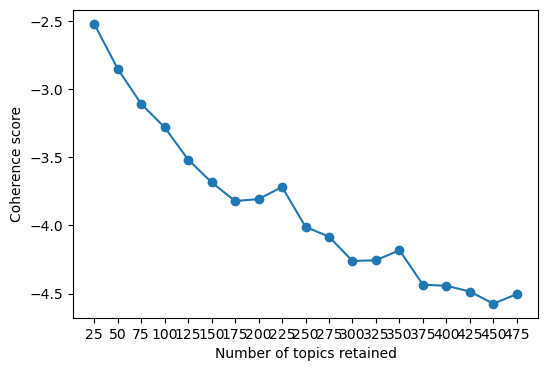

In [19]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(25, 500, 25))
plt.show()

In [20]:
mdl = tp.LDAModel(k=450, corpus=corpus, rm_top=3, min_df=10)
mdl.train(10)

In [21]:
mdl.summary()

<Basic Info>
| LDAModel (current version: 0.12.4)
| 30512 docs, 374339 words
| Total Vocabs: 15997, Used Vocabs: 3446
| Entropy of words: 7.12680
| Entropy of term-weighted words: 7.12680
| Removed Vocabs: car abarth like
|
<Training Info>
| Iterations: 10, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -9.92527
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 10 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 450 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 645325340 (random seed)
| trained in version 0.12.4
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)


# Sentiment Analysis (old)

In [120]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Alvis
[nltk_data]     Cheung\AppData\Roaming\nltk_data...


True

In [135]:
df1=pd.DataFrame()
df1['row_id']=['99999999999']
df1['sentiment_type']='NA999NA'
df1['sentiment_score']=0
df1

,row_id,sentiment_type,sentiment_score
0,99999999999,NA999NA,0


In [233]:
print('Processing sentiment analysis...')
sid = SentimentIntensityAnalyzer()
t_df = df1
for index, row in enumerate(dfCleanCleanText1):
    scores = sid.polarity_scores(row)
    for key, value in scores.items():
        temp = [key,value,index]
        df1['row_id']=index
        df1['sentiment_type']=key
        df1['sentiment_score']=value
        #print(df1)
        t_df = pd.concat([t_df,df1])
#remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.row_id != '99999999999']
#remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()
# only keep rows where sentiment_type = compound
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
print(t_df_cleaned.head(10))

Processing sentiment analysis...
   row_id sentiment_type  sentiment_score
0       0       compound           0.8402
0       1       compound           0.8720
0       2       compound           0.9367
0       3       compound           0.7964
0       4       compound           0.1027
0       5       compound           0.0000
0       6       compound           0.3829
0       7       compound           0.2960
0       8       compound           0.4588
0       9       compound           0.1280


In [234]:
t_df_cleaned

,row_id,sentiment_type,sentiment_score
0,0,compound,0.8402
0,1,compound,0.8720
0,2,compound,0.9367
0,3,compound,0.7964
0,4,compound,0.1027
...,...,...,...
0,1836,compound,0.5994
0,1837,compound,0.2960
0,1838,compound,-0.0387
0,1839,compound,-0.1419


In [235]:
dfCleanCleanText1[0]

'Hello everyone I own a 2016 Abarth 595 which has now developed a squealing noise so I think this is due to the brakes in need of replacement but I’m looking to upgrade from the stock brakes has anyone got any suggestions on upgrades that DON’T cost £1000 😂 any help would be appreciated'

In [157]:
sid.polarity_scores("I am very happy")

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [151]:
sid.polarity_scores("My friend said I shot a solid 2 foot flame out of my car last night. Stock exhaust. Just curious if any of y'all have done it")

{'neg': 0.075, 'neu': 0.683, 'pos': 0.242, 'compound': 0.5994}